Import utils and Matplotlib Settings

In [1]:
import shutil
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import warnings

mlp_params = {
    "figure.figsize": [9, 6],
    "axes.labelsize": 18,
    "axes.titlesize": 17,
    "axes.titlepad": 15,
    "figure.titlesize": 20,
    "axes.labelpad": 10,
    "font.size": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "text.usetex": True if shutil.which("latex") else False,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "figure.dpi": 200,
}
plt.rcParams.update(mlp_params)

warnings.filterwarnings("ignore")

try:
    import tomllib
except ImportError:
    import toml as tomllib

Fetch Settings from TOML file

In [3]:
def parse_toml_params(filename: str) -> dict:
    """
    Parse the toml file containing the parameters

    Args:
    filename: The path to the toml file

    Returns:
    The parameters in a dictionary format
    """
    with open(filename) as file:
        return tomllib.loads(file.read())


params = parse_toml_params("../config.toml")
nodataval = params["map"]["nodataval"]

Input the desired TIFF file

In [11]:
# Replace with your TIFF file path
file_path = "/home/isro/interiit/map_flares/96/Al_Si_combined.tiff"

Histogram of ratio and error values

0.014159204 0.33777955060408194


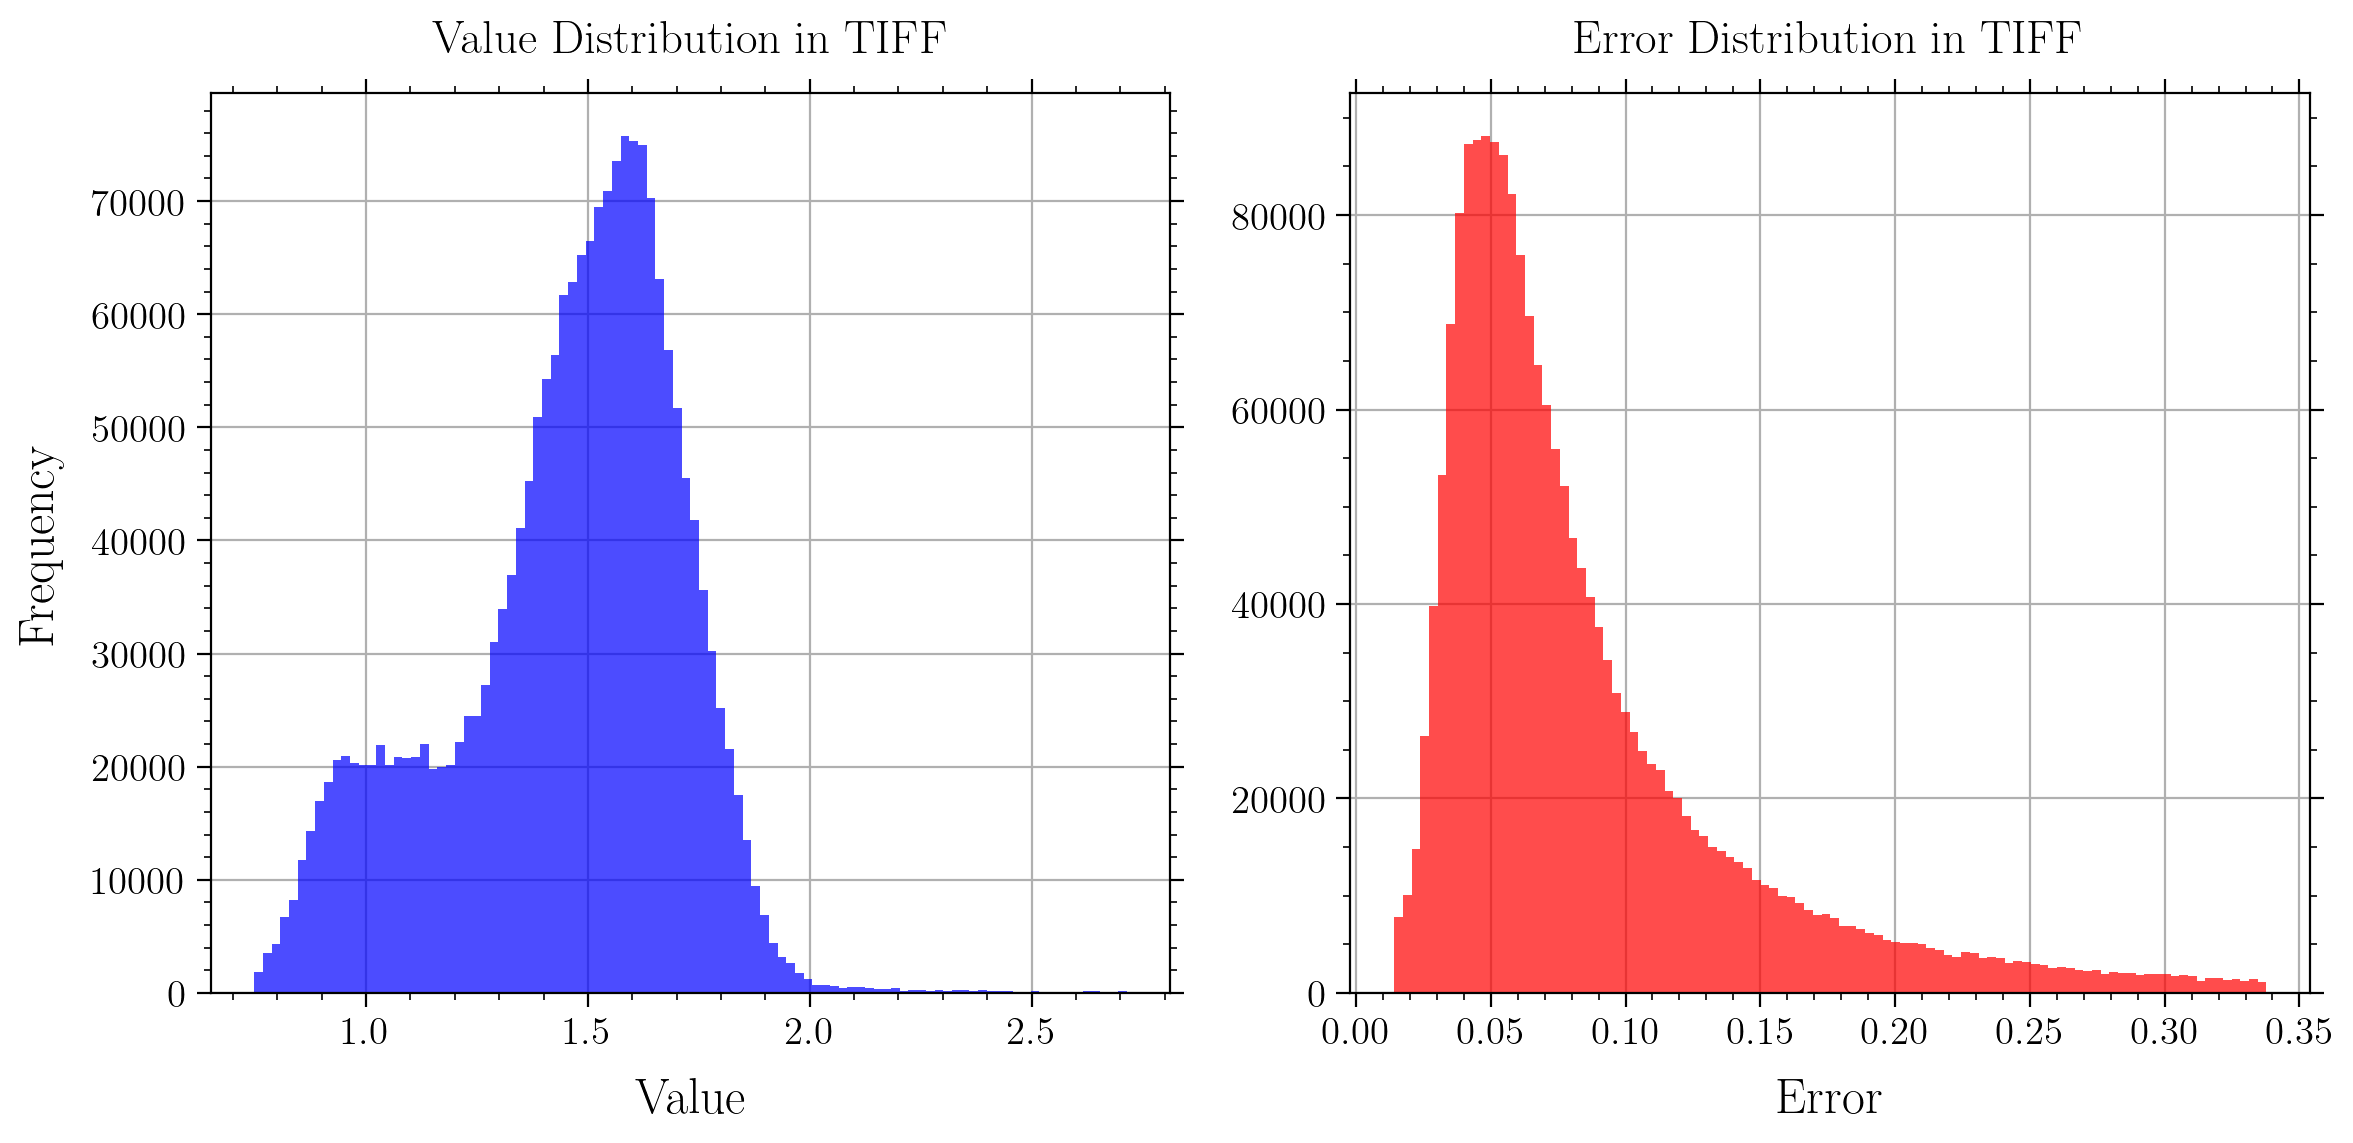

In [12]:
base_image = "./lroc_color_poles_4k.tif"
with rasterio.open(file_path) as src:
    data = src.read(1)  # Read the first band
    errors = src.read(2)
    transform = src.transform
    nodata_val = src.nodata if src.nodata is not None else nodataval
with rasterio.open(base_image) as src:
    base_data = np.stack([src.read(i + 1) for i in range(3)], axis=-1)
data = np.copy(data)
errors = np.copy(errors)
data = np.ma.masked_greater_equal(data, nodata_val)
errors = np.ma.masked_greater_equal(errors, nodata_val)
errors = errors.filled(nodata_val)
zmin_data, zmax_data = ZScaleInterval().get_limits(data[~data.mask])
zmin_errors, zmax_errors = ZScaleInterval().get_limits(errors)
print(zmin_errors, zmax_errors)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(
    data.flatten(),
    bins=100,
    color="blue",
    alpha=0.70,
    range=(zmin_data, zmax_data),
)
ax[0].set_title("Value Distribution in TIFF")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Frequency")
ax[0].grid()

ax[1].hist(
    errors.flatten(),
    bins=100,
    color="red",
    alpha=0.70,
    range=(zmin_errors, zmax_errors),
)
ax[1].set_title("Error Distribution in TIFF")
ax[1].set_xlabel("Error")
ax[1].grid()
plt.tight_layout()
plt.show()

Plot the TIFF ratio and error values on lunar base map

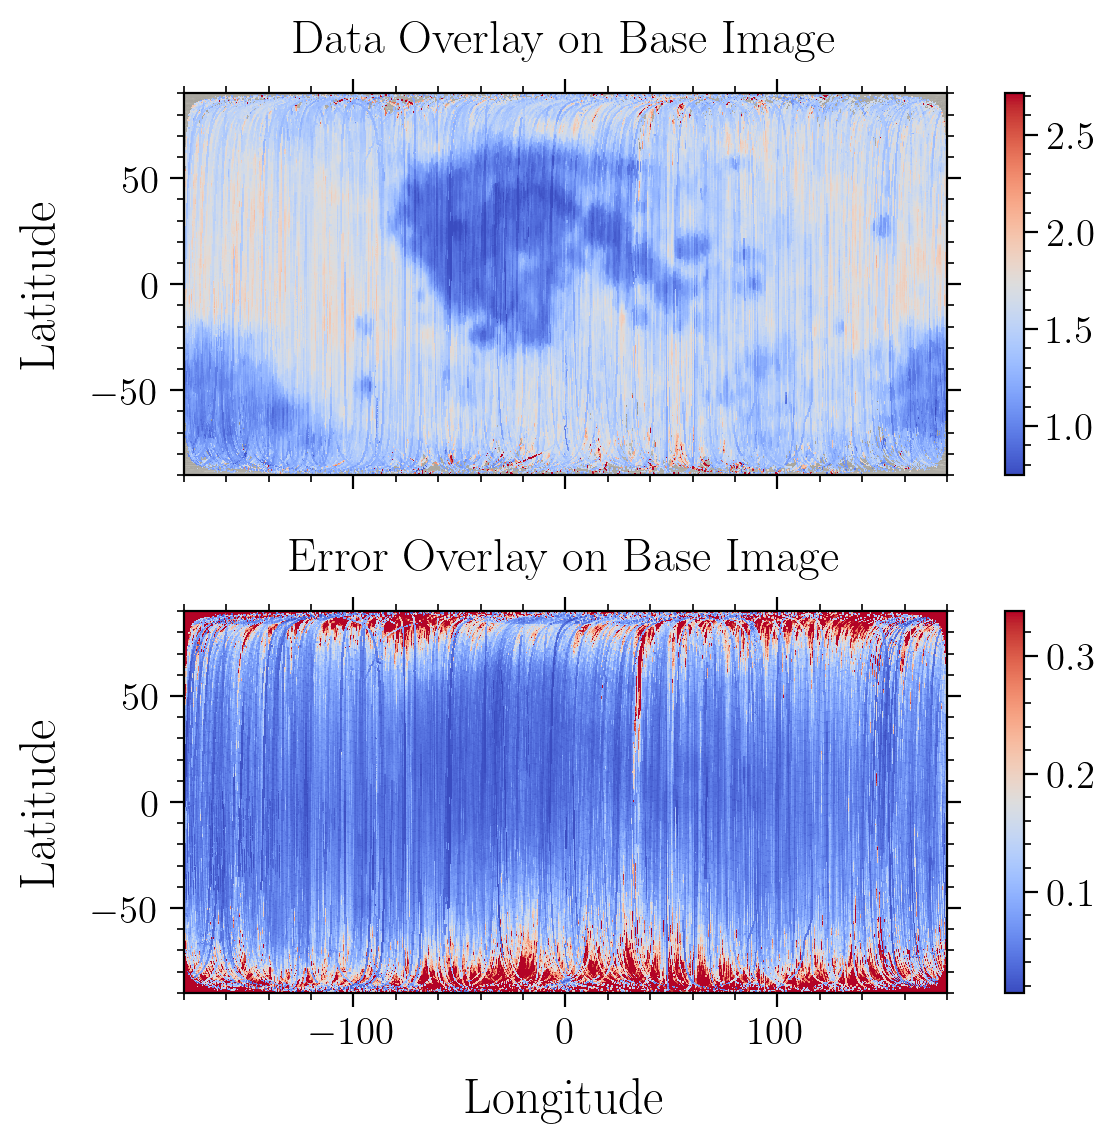

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].imshow(
    base_data,
    extent=(-180, 180, -90, 90),
    interpolation="nearest",
    alpha=1,
)
imshow = ax[0].imshow(
    data,
    extent=(-180, 180, -90, 90),
    cmap="coolwarm",
    interpolation="nearest",
    alpha=1,
    vmin=zmin_data,
    vmax=zmax_data,
)
fig.colorbar(imshow, ax=ax[0], fraction=0.023, pad=0.04)
ax[0].set_title("Data Overlay on Base Image")
ax[0].set_ylabel("Latitude")


ax[1].imshow(
    base_data,
    extent=(-180, 180, -90, 90),
    interpolation="nearest",
    alpha=1,  # Full opacity for the base layer
)
imshow = ax[1].imshow(
    errors,
    extent=(-180, 180, -90, 90),
    cmap="coolwarm",
    interpolation="nearest",
    alpha=1,
    vmin=zmin_errors,
    vmax=zmax_errors,
)
fig.colorbar(imshow, ax=ax[1], fraction=0.023, pad=0.04)
ax[1].set_title("Error Overlay on Base Image")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()